# 1. Building NB algorithm by hand
## 1.1 data preparation

In [1]:
import os
import io
import re

def import_data():
    ham_list = []
    spam_list = []

    for filename in os.listdir("./data/email/ham/"):
        f = open("./data/email/ham/" + filename, mode="r", encoding="latin-1")
        ham_list.append(f.read())

    for filename in os.listdir("./data/email/spam/"):
        f = open("./data/email/spam/" + filename, mode="r", encoding="latin-1")
        spam_list.append(f.read())
    return ham_list, spam_list  

def textParse(bigString):
    listOfTokens = re.split('\W+', bigString)
    regex = re.compile('[0-9]+')  # filter out words with numbers
    return [tok.lower() for tok in listOfTokens if (len(tok) > 2 and not regex.search(tok))]   

def createDataSet(ham_list, spam_list):
    train_ham_list = ham_list[:200]
    test_ham_list = ham_list[200:]
    train_spam_list = spam_list[:50]
    test_spam_list = spam_list[50:]
    listOfPost = []
    listOfClass = []
    listOfTestPost = []
    listOfTestClass = []
    for post in train_ham_list:
        listOfPost.append(textParse(post))
        listOfClass.append(0) # 0 is ham, 1 is spam
    for post in train_spam_list:
        listOfPost.append(textParse(post))
        listOfClass.append(1)
    for post in test_ham_list:
        listOfTestPost.append(textParse(post))
        listOfTestClass.append(0) 
    for post in test_spam_list:
        listOfTestPost.append(textParse(post))
        listOfTestClass.append(1)
    return listOfPost, listOfClass, listOfTestPost, listOfTestClass

In [2]:
ham_list, spam_list = import_data()
listOfPost, listOfClass,listOfTestPost, testClass = createDataSet(ham_list, spam_list)

## 1.2. build classifier
### 1.2.1 create vocabulary list

In [3]:
def createVocab(listOfPost):
    vocabList = []
    for post in listOfPost:
        vocabList.extend(post)
    return list(set(vocabList))

In [4]:
vocab = createVocab(listOfPost)

### 1.2.2 convert documents to word vectors 

In [5]:
import numpy as np

def doc2WordVec(post, vocab):
    retvec = np.zeros(len(vocab))
    for word in post:
        if word in vocab:
            retvec[vocab.index(word)] += 1
    return retvec

In [6]:
# create training matrix
trainMat = np.zeros((0, len(vocab)))
for doc in listOfPost:
    trainMat = np.append(trainMat, doc2WordVec(doc, vocab)[np.newaxis,:], axis=0)

### 1.2.3 calculate probability

In [7]:
def trainNB(trainMat, listOfClass):
    numSpam = np.sum(listOfClass)
    numWords = len(trainMat[0])
    numDocs = len(trainMat)
    p1 = numSpam/numDocs
    p0Vec = np.ones(numWords); p1Vec = np.ones(numWords)
    p0Denom = 2; p1Denom = 2
    for i in range(numDocs):
        if listOfClass[i] == 1:
            p1Vec += trainMat[i]
            p1Denom += np.sum(trainMat[i])
        else:
            p0Vec += trainMat[i]
            p0Denom += np.sum(trainMat[i])  
    p0Vec = np.log(p0Vec/p0Denom)
    p1Vec = np.log(p1Vec/p1Denom)
    return p0Vec, p1Vec, p1

In [8]:
p0V, p1V, pSpam = trainNB(trainMat, listOfClass)

In [9]:
p0V

array([ -9.7706188 , -11.38005671, -11.38005671, ..., -11.38005671,
        -9.7706188 , -10.28144442])

### 1.2.4 make classfier

In [10]:
# need a diffeent way to convert from words to vector
# set word to 1, on occurance
def doc2WordVec1(post, vocab): # todo: change bad naming
    retvec = np.zeros(len(vocab))
    for word in post:
        if word in vocab:
            retvec[vocab.index(word)] = 1
    return retvec

In [11]:
def classify(vector2Classify, p0V, p1V, pSpam):
    probSpam = np.sum(doc2WordVec1(vector2Classify, vocab)*p1V) + np.log(pSpam)
    probHam = np.sum(doc2WordVec1(vector2Classify, vocab)*p0V) + np.log(1 - pSpam)
    if probSpam > probHam:
        return 1
    else:
        return 0

## 1.3. test model

In [12]:
def testModel(testData, testClass, p0V, p1V, pSpam):
    testResult = [];
    for i in range(len(testData)):
        testResult.append(classify(testData[i], p0V, p1V, pSpam))
    return testResult

In [13]:
result = testModel(listOfTestPost, testClass, p0V, p1V, pSpam)

Text(89.18, 0.5, 'predicted label')

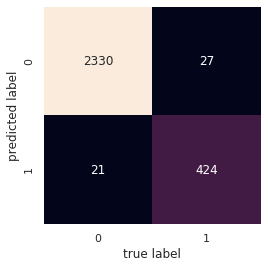

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(testClass, result)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label')

In [22]:
(mat[0,0] + mat[1,1])/len(result)

0.9828693790149893